The below UNET code is inspired by this tutorial: https://www.tensorflow.org/tutorials/images/segmentation

# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.test.is_gpu_available()

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import random
from random import shuffle
from PIL import Image

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Creating Image Data Generators

## New Data Gens

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

In [ ]:
sz = (128, 128)
BATCH_SIZE = 10

In [ ]:
rgb_images_dir = '/home/path/to/Images'
annotations_color_dir = '/home/path/to/Masks'

In [ ]:
# we create two instances with the same arguments
data_gen_args = dict(
                     rescale=1./255,
                     validation_split=0.1
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

#Splitting training and validation without applying same transformations to both datasets:
#https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in
#https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
train_image_generator = image_datagen.flow_from_directory(
    rgb_images_dir,
    target_size = sz,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=seed)
train_mask_generator = mask_datagen.flow_from_directory(
    annotations_color_dir,
    target_size = sz,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=seed)

val_image_generator = image_datagen.flow_from_directory(
    rgb_images_dir,
    target_size = sz,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=seed)
val_mask_generator = mask_datagen.flow_from_directory(
    annotations_color_dir,
    target_size = sz,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=seed)

 #about resetting test generators
#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720


In [ ]:
#If this doesn't work, applying mask changes
#https://github.com/keras-team/keras-preprocessing/issues/125
def prepare_mask_crop(masks):
  new_masks = [] 
  for i in range (np.shape(masks)[0]):
    mask_datapoint = masks[i]
    r = mask_datapoint[:,:,0]
    g = mask_datapoint[:,:,1]
    r[r<(150/255)]=0 
    r[r>(150/255)]=1
    g[g<(150/255)]=0 
    g[g>(150/255)]=2
    merged = np.maximum(r,g)
    new_masks.append(merged)
  new_masks = np.expand_dims(new_masks,3)
  return new_masks

In [ ]:
#If this doesn't work, applying mask changes
#https://github.com/keras-team/keras-preprocessing/issues/125
def prepare_mask_centroid(masks):
  new_masks = [] 
  for i in range (np.shape(masks)[0]):
    mask_datapoint = masks[i]
    b= mask_datapoint[:,:,2]
    b[b<(150/255)]=0 
    b[b>(150/255)]=1
    new_masks.append(b)
  new_masks = np.expand_dims(new_masks,3)
  return new_masks

In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (imgs, msks) in train_generator:
        msks_crop = prepare_mask_crop(msks)
        msks_centroid = prepare_mask_centroid(msks)
        yield (imgs, [msks_crop, msks_centroid])

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
 #for joining generators
 #https://stackoverflow.com/questions/3211041/how-to-join-two-generators-in-python
 #https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs/49405175#comment89680557_49405175
my_train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
my_val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

In [ ]:
x,y = next(my_train_generator)

In [ ]:
for i in range(len(x)):
  sample_image = x[i]
  print(sample_image.shape)
  sample_mask_crop = y[0][i]
  sample_mask_centroid = y[1][i]
  print(sample_mask_centroid.shape)
  display([sample_image,sample_mask_crop, sample_mask_centroid])

sample_image = x[0]
sample_mask_crop = y[0][0]
sample_mask_centroid = y[1][0]

In [ ]:
z,w = next(my_val_generator)

# Define the model
The model being used here is a modified U-Net. A pretrained model (MobileNetV2) is used as the encoder. The decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
up_stack_crop = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels, inputs):
  #x = inputs

  # Downsampling through the model
  skips = down_stack(inputs)
  print('skips', skips)
  last_downsampled_layer = skips[-1]
  x = last_downsampled_layer
  skips = list(reversed(skips[:-1]))

  ##################################################
  ############# Crop/Weed branch ###################
  ##################################################

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack_crop, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])
model = unet_model(OUTPUT_CHANNELS, inputs)

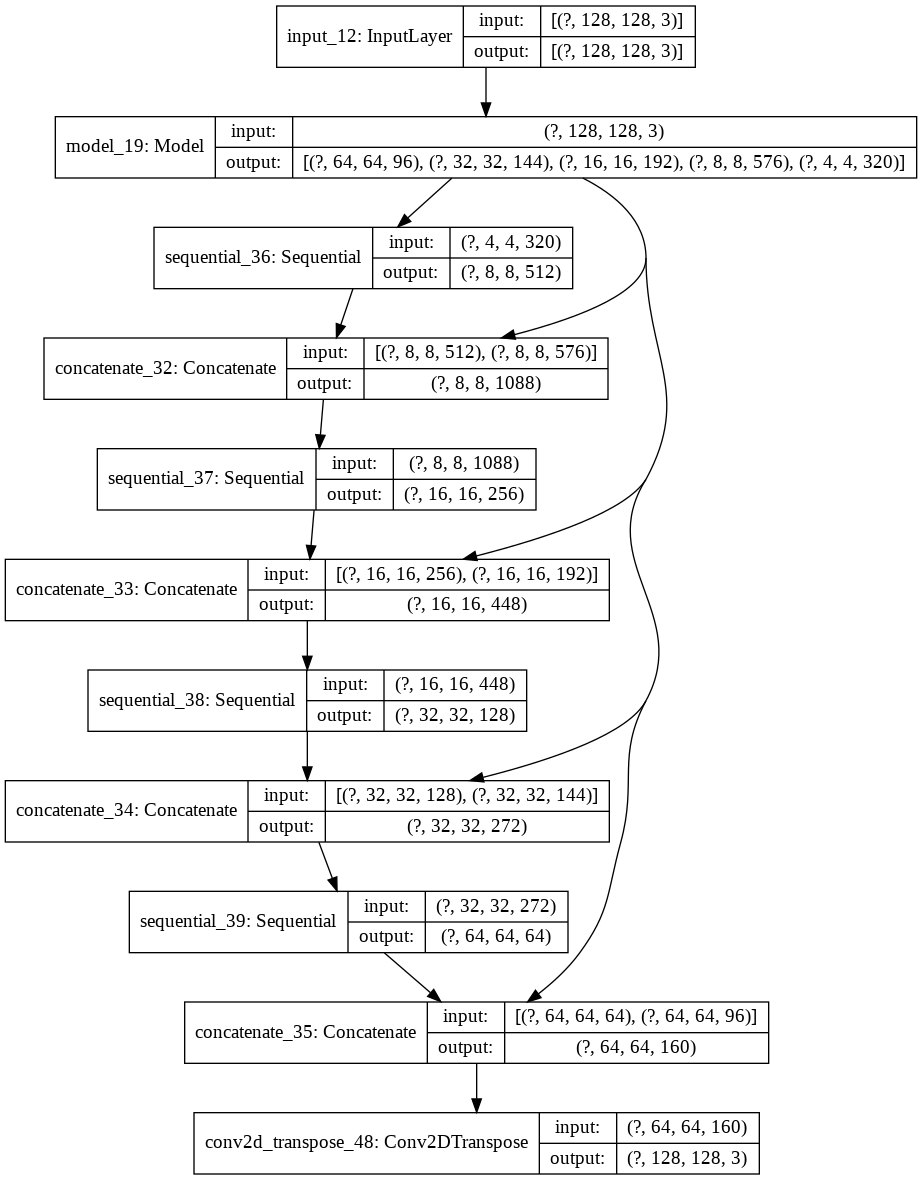

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

In [ ]:
model.load_weights('/home/path/to/weights/name.h5')

## Appending the second branch

In [ ]:
encoder = model.get_layer(index=1)
print(encoder)
print(encoder.output)

In [ ]:
# Downsampling through the model
skips = encoder(inputs)
y = skips[-1]
skips = list(reversed(skips[:-1]))
print('skips', skips)

In [ ]:
up_stack_centroid = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
##################################################
############# Centroid branch ####################
##################################################
for up, skip in zip(up_stack_centroid, skips):
  print('up', up)
  print('skip', skip)
  y = up(y)
  concat = tf.keras.layers.Concatenate()
  y = concat([y, skip])

# This is the last layer of the model
y = tf.keras.layers.Conv2DTranspose(
    OUTPUT_CHANNELS, 3, strides=2,
    padding='same')(y)  #64x64 -> 

y = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation=None)(y)
y_branch = tf.keras.layers.Activation('sigmoid')(y)

In [ ]:
x_branch = model.layers[-1]
x_branch=x_branch.output

In [ ]:
joint_model = tf.keras.Model(inputs=inputs, outputs=[x_branch,y_branch])

In [ ]:
joint_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model[4][4]                      
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 8, 8, 1088)   0           sequential_12[0][0]        

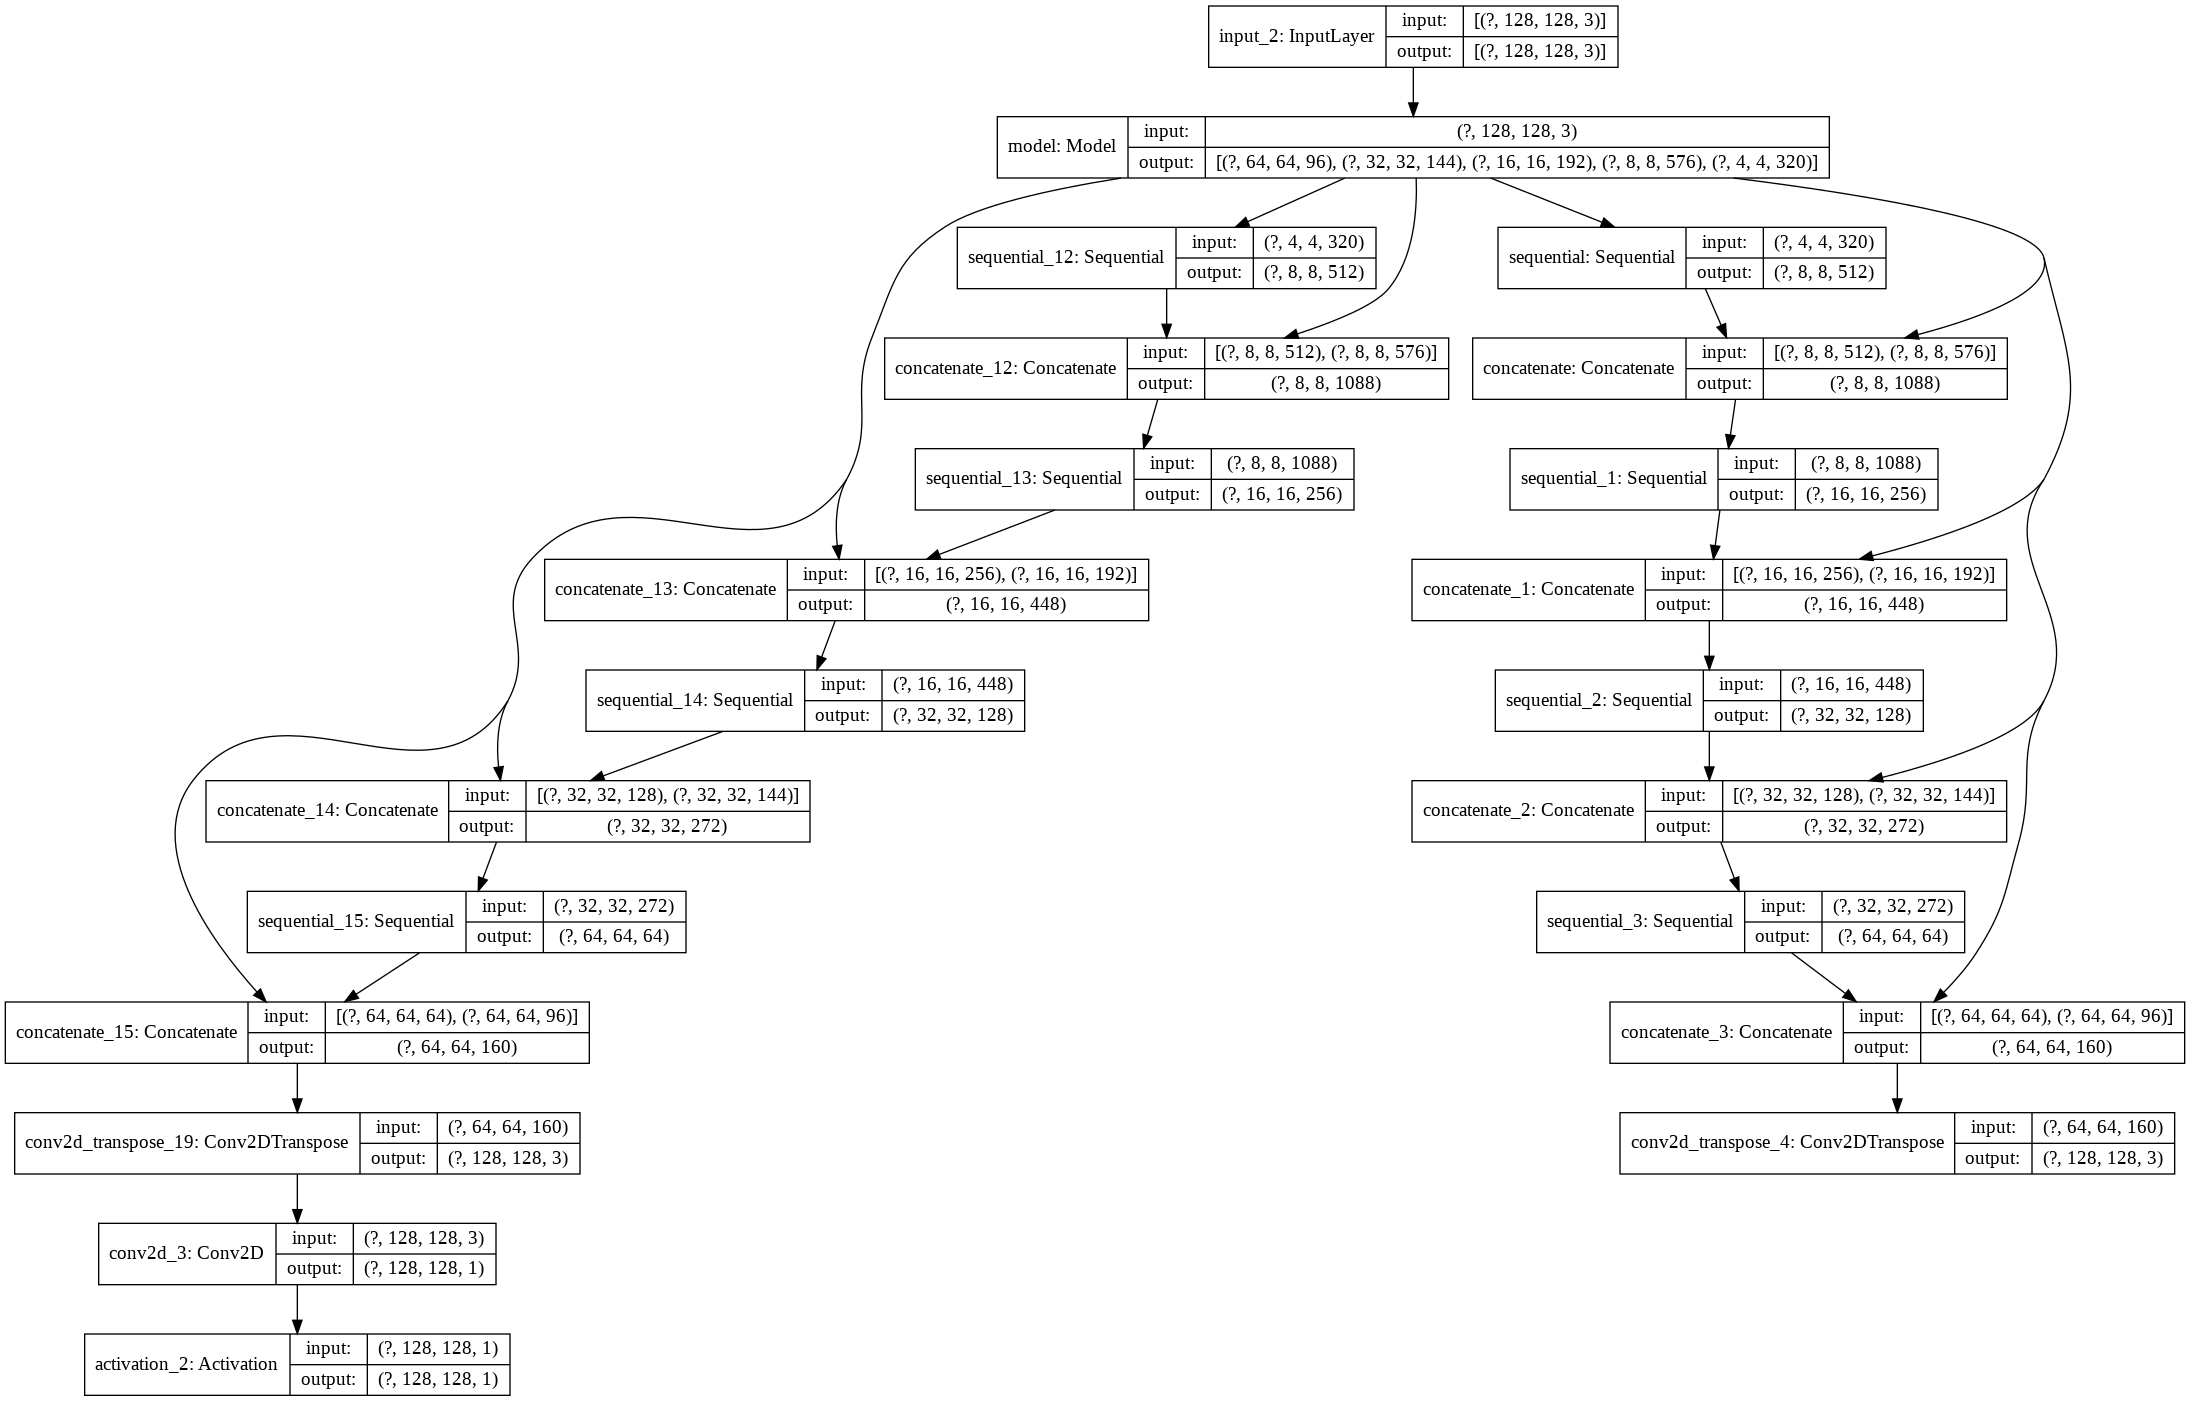

In [ ]:
tf.keras.utils.plot_model(joint_model, show_shapes=True)

In [ ]:
joint_model.get_layer(index=0).set_weights(model.get_layer(index=0).get_weights())
joint_model.get_layer(index=0).trainable = False
joint_model.get_layer(index=1).set_weights(model.get_layer(index=1).get_weights())
joint_model.get_layer(index=1).trainable = False

for i in range(2,len(joint_model.layers)):
  j_layer = joint_model.get_layer(index=i)
  if j_layer.name != "conv2d_3" and j_layer.name !="activation_2":
    for j in range(2,len(model.layers)):
      layer = model.get_layer(index=j)
      if str(j_layer.output).split(',')[1:5] == str(layer.output).split(',')[1:5]:
        print('equal', j_layer.output, layer.output)
        j_layer.set_weights(layer.get_weights())

In [ ]:
joint_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model[4][4]                      
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 8, 8, 1088)   0           sequential_12[0][0]        

# Define the IoU metric

In [ ]:
def mean_iou(y_true, y_pred):
  inter = tf.math.count_nonzero(tf.logical_and(tf.not_equal(y_true, 0), tf.equal(y_true,y_pred)))
  union = tf.math.count_nonzero(tf.add(y_true, y_pred))
  my_iou = tf.cast(inter/union, 'float32')
  return my_iou

In [ ]:
def mean_iou(y_true, y_pred):
  yt0 = y_true
  yp0 = K.cast(y_pred, 'float32')
  inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
  union = tf.math.count_nonzero(tf.add(yt0, yp0))
  iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
  return iou

# Compile the model
The network is trying to assign each pixel a label. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class.

In [ ]:
joint_model.compile(optimizer='adam',
              loss=["categorical_crossentropy","categorical_crossentropy"],loss_weights=[0.1,0.9],
              metrics=["accuracy"]
              )

# Viewing the model performance before training the trainable parameters

Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
from keras import backend as K

In [ ]:
threshold = 0.6

In [ ]:
def create_meristem_mask(pred_mask):
  pred_mask=pred_mask[0]
  pred_mask = K.cast(pred_mask > threshold, 'float32')
  return pred_mask

In [ ]:
def create_weed_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    pred_x, pred_y = next(test_dataset)
    for i in range (num):
      image, mask = pred_x[i], pred_y[i]

      tic = time.perf_counter()
      pred_mask = joint_model.predict(image[tf.newaxis, ...])
      toc = time.perf_counter()
      print(f'Predicted the image in {toc - tic:0.4f} seconds')

      pred_mask_crop = create_weed_mask(pred_mask[0])
      pred_mask_centroid = create_meristem_mask(pred_mask[1])

      my_iou_crop =  mean_iou(mask[0], pred_mask_crop)
      print('My Mean IoU for sample image: ', tf.keras.backend.eval(my_iou_crop))

      my_iou_centroid =  mean_iou(mask[1], pred_mask_centroid)
      print('My Mean IoU for sample image: ', tf.keras.backend.eval(my_iou_centroid))
      
      display([image, mask[0], pred_mask_crop])
      display([image, mask[1], pred_mask_centroid])
  else:
    pred_mask = joint_model.predict(sample_image[tf.newaxis, ...])
    pred_mask_crop = create_weed_mask(pred_mask[0])
    pred_mask_centroid = create_meristem_mask(pred_mask[1])
    my_iou =  mean_iou(sample_mask_crop, pred_mask_crop)
    print('My Mean IoU for sample crop mask: ', tf.keras.backend.eval(my_iou))

    my_iou =  mean_iou(sample_mask_centroid, pred_mask_centroid)
    print('My Mean IoU for sample centroid mask: ', tf.keras.backend.eval(my_iou))

    display([sample_image, sample_mask_crop, pred_mask_crop])
    display([sample_image, sample_mask_centroid, pred_mask_centroid])

In [ ]:
show_predictions()

# Define the Callback

In [ ]:
class ShowPredictions(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
def build_callbacks():
  checkpointer = ModelCheckpoint(filepath='/home/path/to/weights/name.h5',
                            verbose=0,
                            save_best_only=True,
                            save_weights_only=True)


  callbacks = [checkpointer,
               ShowPredictions()]
               
  return callbacks

# Train the model

In [ ]:
STEPS_PER_EPOCH = np.floor(918/BATCH_SIZE)
VALIDATION_STEPS = np.floor(101/BATCH_SIZE)
print(STEPS_PER_EPOCH, VALIDATION_STEPS)

In [ ]:
model_history = joint_model.fit_generator(my_train_generator,epochs=200,
                                    steps_per_epoch=STEPS_PER_EPOCH,
                                    validation_data=my_val_generator,
                                    validation_steps=VALIDATION_STEPS,
                                    callbacks=build_callbacks()
                                    )

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(7)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Load a saved model

In [ ]:
model.load_weights('/home/path/to/weights/name.h5')

In [ ]:
model_noearly = unet_model(OUTPUT_CHANNELS)
model_noearly.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_noearly.load_weights('/home/path/to/weights/name.h5')

# Make predictions

See how the system behaves on a set of images

## Show predictions for external images

In [ ]:
home_dir = '/home/path/to/images'
rgb_images = 'images'
annotations_color = 'masks'
sz = (128, 128)

base_dir = os.path.join(home_dir, 'path')
rgb_images_dir = os.path.join(base_dir, rgb_images)
annotations_color_dir = os.path.join(base_dir, annotations_color)

for file in os.listdir(rgb_images_dir):
  print('Predicting for file:', file)
  img_path = os.path.join(rgb_images_dir, file) 
  ext_image = Image.open(img_path)
  print(ext_image.format)
  print(ext_image.mode)
  ext_image = ext_image.resize(sz)
  ext_image = np.array(ext_image)
  ext_image =ext_image[:,:,0:3]

  if file in os.listdir(annotations_color_dir):
    mask_path = os.path.join(annotations_color_dir, file) 
    ext_mask = Image.open(mask_path)
    ext_mask = ext_mask.resize(sz)
    ext_mask = np.array(ext_mask)
  else:
    ext_mask = np.zeros((128, 128, 1))

  ext_pred_mask = model.predict(ext_image[tf.newaxis, ...])
  ext_pred_mask = create_mask(ext_pred_mask)

  display_list = [ext_image, ext_mask, ext_pred_mask]

  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Second Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
next(my_train_generator)

In [ ]:
show_predictions(my_train_generator, 10)